# Basic Iterative Method

Add a brief description here

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [3]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [4]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack


BIM requires the following function, which clips pixel values of an image $X^\prime$:

**TODO**
Fix explanation!!

Similar to the fast method we update the pixel values:

\begin{equation}
\tag{2.1}
\widetilde{X}_{n+1} = Clip_{X, \epsilon} \{ \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true})) \}
\end{equation}




Here, the Clip function is defined as:

\begin{equation}
\tag{2.2}
Clip_{X, \epsilon} \{ X^\prime \} (x, y, z) = min\{ 255, X(x, y, z) + \epsilon, max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \} \}
\end{equation}

For the implementation we initialize:

\begin{equation}
\tag{2.3}
\widetilde{X}_{0} = X
\end{equation}

For the implementation we do for the number of iterations `n`:


a) Compute $ X^\prime = \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true}))$ as used in equation (2.1)

b) Compute $ X(x, y, z) + \epsilon $ and $ X(x, y, z) - \epsilon $

c) Evaluate equation (2.2) using steps a) and b)

$max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \}$ (?)

d) Retrieve updated adversarial image $\widetilde{X}_{1}$ as given in equation (2.1)

Values for the hyper parameters given in [2]:

- $\alpha = 1$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

In [5]:
def apply_BIM(model, image, label, alpha, epsilon, num_iterations=2):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    model          -- Model under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    label          -- Label from image as tensor of shape (1)
    alpha          -- Hyperparameter for iterative step
    epsilon        -- Hyperparameter for sign method
    num_iterations -- Number of iterations to perform
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    ## Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 224, 224]))
    assert(label.shape == torch.Size([1]))
    
    ## Initialize adversarial image as image according to equation (3)
    image_adver = image.clone()    
    
    for i in range(num_iterations):
        
        ## Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        ## Compute cost with example image_adersarial        
        pred = model(image_adver)        
        loss = F.nll_loss(pred, label)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        ## Check if gradient exists
        assert(image_adver.grad is not None)
               
        ## Compute X_prime according to equation (1)
        image_prime = image_adver + alpha * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
    
        ## Apply clip function to image_prime as in equation (2)       
        image_plus = image + epsilon
        image_minus = image - epsilon
        assert(torch.equal(image_plus, image) == False)
        
        # Equation 1.2
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(torch.tensor(0, dtype=torch.float), third_part_1)
              
        # Equation (2)
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(torch.tensor(255, dtype=torch.float), image_adver)                        

    
    return image_adver

In [6]:
def compare_examples_bim(alpha, epsilon, idx):
    '''
    Generates an example using BIM. Prints infos and plots clean and adversarial image side-by-side.
    
    Inputs:
    epsilon -- Hyperparameter for BIM
    alpha   -- Hyperparameter for BIM
    idx     -- Index of sample   
    '''
    
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    print("Number of iterations: " + str(num_iterations))
    
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)

    image_adv = apply_BIM(model, image_clean, target_label, alpha, epsilon, num_iterations=num_iterations)

    ## Predictions
    _, _, _, conf_clean, label_clean = predict(model, image_clean, target_label)
    _, _, _, conf_adv, label_adv = predict(model, image_adv, target_label)

    ## Plot
    plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_label)

### 2.1 Individual Images

Do some cool analysis here. In particularm find one of the examples where a wrong class is predicted with high confidence. Apparently there aren't neccessarily that many in the ImageNet dataset?

Number of iterations: 1
			Clean image	 Adversarial image

Actual class: 		coral reef			coral reef
Predicted class: 	coral reef			rock crab, Cancer irroratus
Confidence: 		85.77%				7.19%



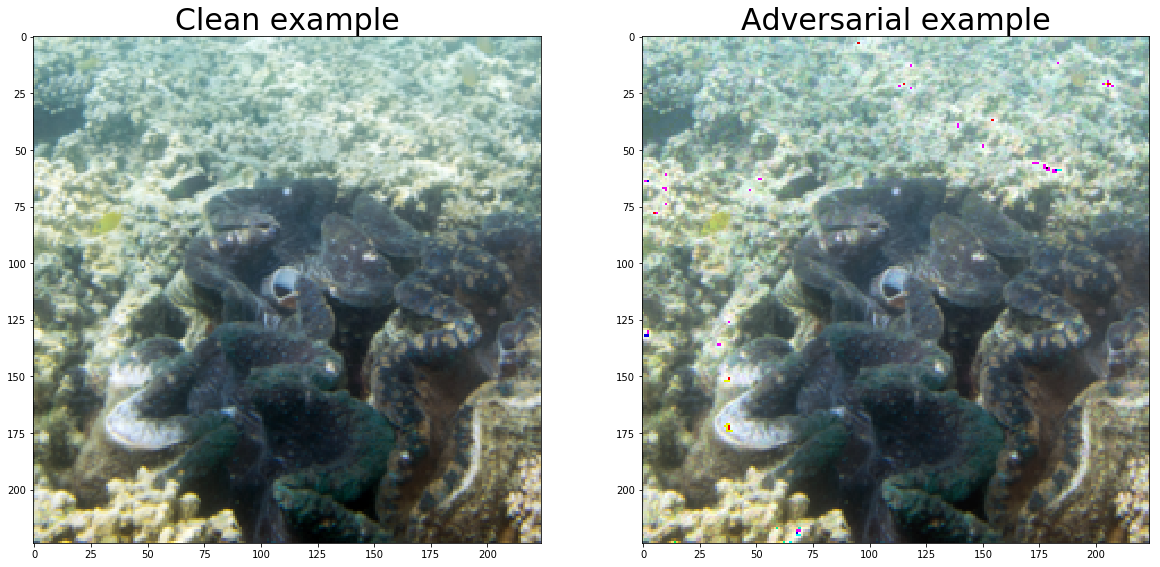

In [7]:
idx = 298
epsilon = 30/255 ## 
alpha = 1 # As in the paper

compare_examples_bim(alpha, epsilon, idx)

Number of iterations: 1
			Clean image	 Adversarial image

Actual class: 		cliff, drop, drop-off			cliff, drop, drop-off
Predicted class: 	megalith, megalithic structure			viaduct
Confidence: 		23.26%				6.57%



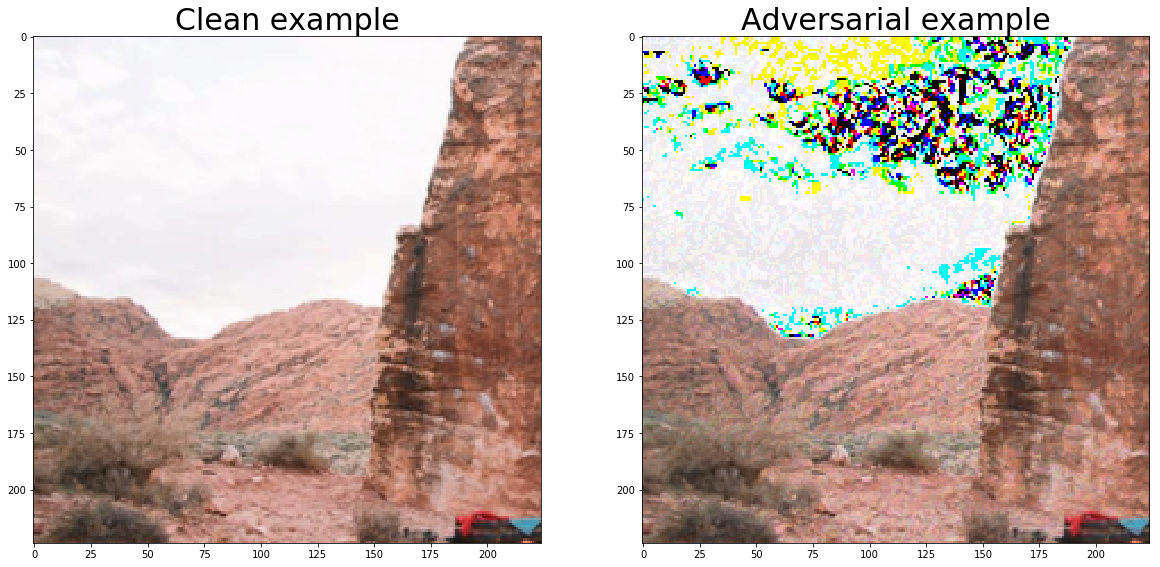

In [8]:
idx = 781
epsilon = 30/255 ## 
alpha = 1 # As in the paper

compare_examples_bim(alpha, epsilon, idx)

It can be seen that from a value of around $\epsilon = \frac{10}{255}$ the pertubation becomes visible to the human eye. Note that the model predicts a different class here with a very low confidence.

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

In [ ]:
# Set hyperparameter
epsilons = [0, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]
alpha = 1 # As in the paper


# Initialize lists
num_iter = []
accurcy_top1 = []
accurcy_top5 = []
confidence_adversarial = []


for epsilon in epsilons:
   
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    num_iter.append(num_iterations)
    
    acc_sub_adver_top1 = []
    acc_sub_adver_top5 = []
    conf_sub_adver = []
    i = 1
    
    for image_clean, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon*255))
        print("Sample: " + str(i))
        print("Number of iterations: " + str(num_iterations))
        print("Average adv. accuracy: {:.2f}\nAverage adv. confidence: {:.2f}".format(np.mean(acc_sub_adver_top1), np.mean(np.mean(conf_sub_adver) )) )
        
        # Predict with clean image
        _, corr, _, conf, _ = predict(model, image_clean, label)

        # Generate adversarial example only if initial prediction was correct
        if corr == 1:
            # Predict with adversarial image
            image_adversarial = apply_BIM(model, image_clean, label, alpha, epsilon, num_iterations=num_iterations)
            _, top1, top5, conf, _ = predict(model, image_adversarial, label)
            acc_sub_adver_top1.append(top1)
            acc_sub_adver_top5.append(top5)
            conf_sub_adver.append(conf)
            
        else:
            acc_sub_adver_top1.append(0)
            acc_sub_adver_top5.append(0)
            conf_sub_adver.append(0)
            
        i += 1

    # Add accuracies and confidences
    accurcy_top1.append(np.mean(acc_sub_adver_top1))
    accurcy_top5.append(np.mean(acc_sub_adver_top5))
    confidence_adversarial.append(np.mean(conf_sub_adver))


# Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Num_Iter"] = num_iter
result["Accuracy Top 1"] = accurcy_top1
result["Accuracy Top 5"] = accurcy_top5
result["Confidence"] = confidence_adversarial
result.to_csv("results/googleNet_ImageNet_BIM_2.csv")

## 3. Discussion

In [9]:
# Load results
result = pd.read_csv("results/googleNet_ImageNet_BIM.csv")
accurcy_top1 = result["Accuracy Top 1"]
accurcy_top5 = result["Accuracy Top 5"]
confidence_adversarial = result["Confidence"]
epsilon = result["Epsilon_255"]

KeyError: 'Accuracy Top 1'

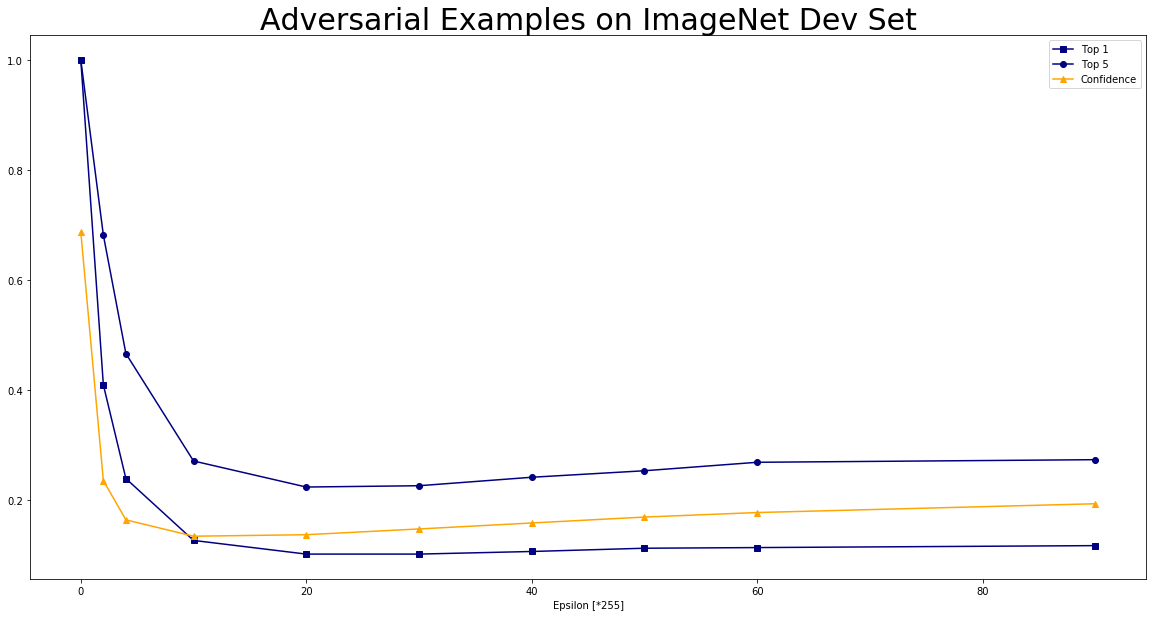

In [12]:
# Plot
plt.plot(e, accurcy_top1, "s-", color="navy", label="Top 1")
plt.plot(e, accurcy_top5, "o-", color="navy", label="Top 5")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples from BIM on ImageNet", fontsize=30)
plt.legend()
plt.show()

#plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_BIM2.pdf")
#plt.savefig("plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_BIM2.png")

Some text ...

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*